In [18]:
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
from lsst.pex.exceptions import LengthError

import lsst.afw.math as afwMath
import lsst.afw.detection as afwDetect
import lsst.afw.display as afwDisplay

rand = afwMath.Random()

In [19]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [20]:
def displayImage(image):
    plt.imshow(image.getArray(), origin='lower', interpolation='none', cmap='gray' )#, vmin=-zptp, vmax=zptp)
    plt.show()
    
display = afwDisplay.getDisplay()
display.setMaskTransparency(50, None) # Set the mask transparency

Box2I((300, 500), (2299, 2547))
Why didn't that work?
GOTCHA 1: PARENT vs. LOCAL we need to take into account XY0.
0.0
Box2I((300, 500), (2299, 2547))
Box2I((310, 510), (409, 609))


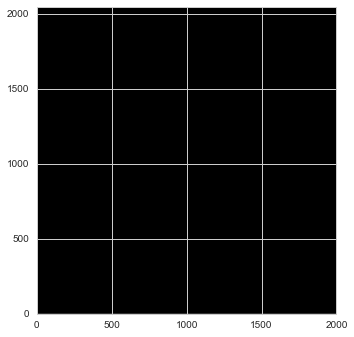

In [21]:
n_objects = 1000

box = afwGeom.BoxI(afwGeom.PointI(300, 500), afwGeom.ExtentI(2000, 2048))

im = afwImage.ImageF(box)
print(im.getBBox())
subbox = afwGeom.BoxI(afwGeom.PointI(10, 10), afwGeom.ExtentI(100, 100))
try:
    im2 = afwImage.ImageF(im, subbox)
except LengthError:
    print("Why didn't that work?\nGOTCHA 1: PARENT vs. LOCAL we need to take into account XY0.")
    im2 = afwImage.ImageF(im, subbox, afwImage.LOCAL)
    
print im.getArray().mean()
print im.getBBox()
print im2.getBBox()
displayImage(im)

In [22]:
buffer_xy = 150 # Don't put objects near the edges
x_positions = [rand.uniformInt(im.getWidth() - 2*buffer_xy) + buffer_xy for i in xrange(n_objects)]
y_positions = [rand.uniformInt(im.getHeight() - 2*buffer_xy) + buffer_xy for i in xrange(n_objects)]

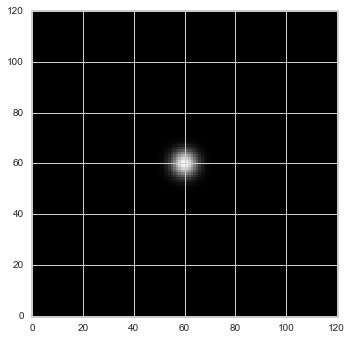

Box2I((-60, -60), (60, 60))


In [23]:
psf_size = 121 # This has to be odd
sigma = 0.7/0.2 # seeing in arcsec/pixel size in arcsec
peak_val = 6000

psf = afwDetect.GaussianPsf(psf_size, psf_size, sigma)
psf_im = psf.computeImage()

max_val = psf_im.getArray().max()

psf_im /= max_val
psf_im *= peak_val

displayImage(psf_im)
print psf_im.getBBox()

Why didn't this work?
GOTCHA 2: It's because Psf.computeImage() returns an ImageD. You can't add an ImageD and an ImageF.  They have to be the same type.




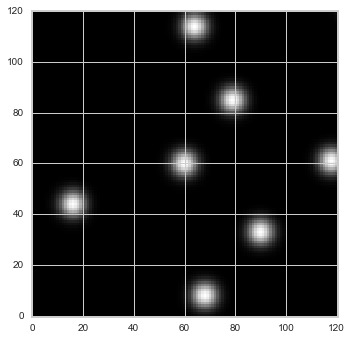

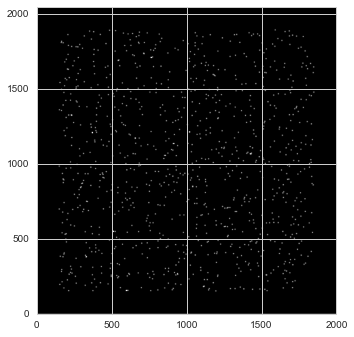

112.748


In [24]:
for x, y in zip(x_positions, y_positions):
    x0 = x - (psf_size - 1)/2
    y0 = y - (psf_size - 1)/2
    box = afwGeom.BoxI(afwGeom.PointI(x0, y0), afwGeom.ExtentI(psf_size, psf_size))
    subim = afwImage.ImageF(im, box, afwImage.LOCAL)
    try:
        subim += psf_im
    except NotImplementedError:
        print("Why didn't this work?\nGOTCHA 2: It's because Psf.computeImage() returns an ImageD. "\
              "You can't add an ImageD and an ImageF.  They have to be the same type.\n\n")
        psf_im = psf_im.convertF()
        subim += psf_im
        
displayImage(subim)
displayImage(im)
print im.getArray().mean()

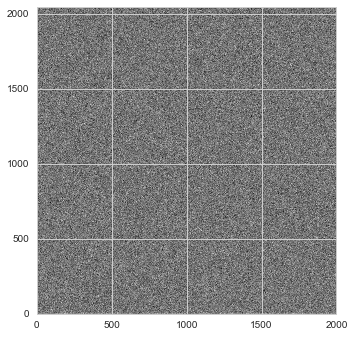

1000.01 31.6397


In [11]:
back_im = afwImage.ImageF(im.getBBox())
#displayImage(back_im)
afwMath.randomPoissonImage(back_im, rand, 1000)
displayImage(back_im)
print back_im.getArray().mean(), back_im.getArray().std()

In [12]:
print im.getArray().mean(), im.getArray().std()
im += back_im
print im.getArray().mean(), im.getArray().std()

225.495 1170.54
1225.51 1170.98


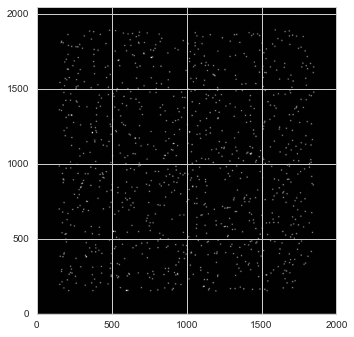

In [13]:
display.mtv(im)
display.frame = display.incrDefaultFrame()
display.setMaskTransparency(50, None) # Set the mask transparency
displayImage(im)

In [14]:
mask = afwImage.MaskU(im.getBBox())
masked_im = afwImage.MaskedImageF(im, mask, im)

threshold = afwDetect.createThreshold(5., 'stdev')
fs = afwDetect.FootprintSet(masked_im, threshold, 'DETECTED')
display.mtv(masked_im)
display.frame = display.incrDefaultFrame()
display.setMaskTransparency(50, None) # Set the mask transparency
print("Wait a second.  Why is everything detected?\nGOTCHA 5: We need to subtract the background.")

Wait a second.  Why is everything detected?
GOTCHA 5: We need to subtract the background.


In [15]:
bctrl = afwMath.BackgroundControl(11, 11)
bkgd = afwMath.makeBackground(masked_im, bctrl)
print masked_im.getImage().getArray().mean()
masked_im -= bkgd.getImageF()
print bkgd.getImageF().getArray().mean()
print masked_im.getImage().getArray().mean()

1225.51
1001.64
223.867
